## Exploring text data

If you haven't installed wordcloud yet: run "!pip install wordcloud" in a jupyter notebook cell to install the library.

In [6]:
#Imports
import re
import unicodedata
import pandas as pd
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from env import get_connection

In [7]:
#Get SQL database url
url = get_connection('spam_db')

In [8]:
#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [9]:
#Read SQL
df = pd.read_sql(query, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
#Value counts of labels
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [11]:
#Define function to clean up text data
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [12]:
#Clean the text data by label
ham_words = clean_text(' '.join(df[df['label'] == 'ham']['text']))
spam_words = clean_text(' '.join(df[df['label'] == 'spam']['text']))
all_words = clean_text(' '.join(df['text']))

In [13]:
#Save the value counts of each series to a variable
ham_counts = pd.Series(ham_words).value_counts()
spam_counts = pd.Series(spam_words).value_counts()
all_counts = pd.Series(all_words).value_counts()

In [14]:
#Check
spam_counts.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [15]:
#Combine the value counts into one dataframe
word_freq = pd.concat([ham_counts, spam_counts, all_counts], axis=1)
word_freq.head()

,0,1,2
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [16]:
#Check for nulls
word_freq.isna().sum()

0    1918
1    6086
2       0
dtype: int64

In [17]:
#Rename columns and fill null values
word_freq.columns = ['ham', 'spam', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,ham,spam,all
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [18]:
#Check datatypes of columns
word_freq.dtypes

ham     float64
spam    float64
all       int64
dtype: object

In [19]:
#Recast all columns as integers
word_freq = word_freq.astype('int')
word_freq.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


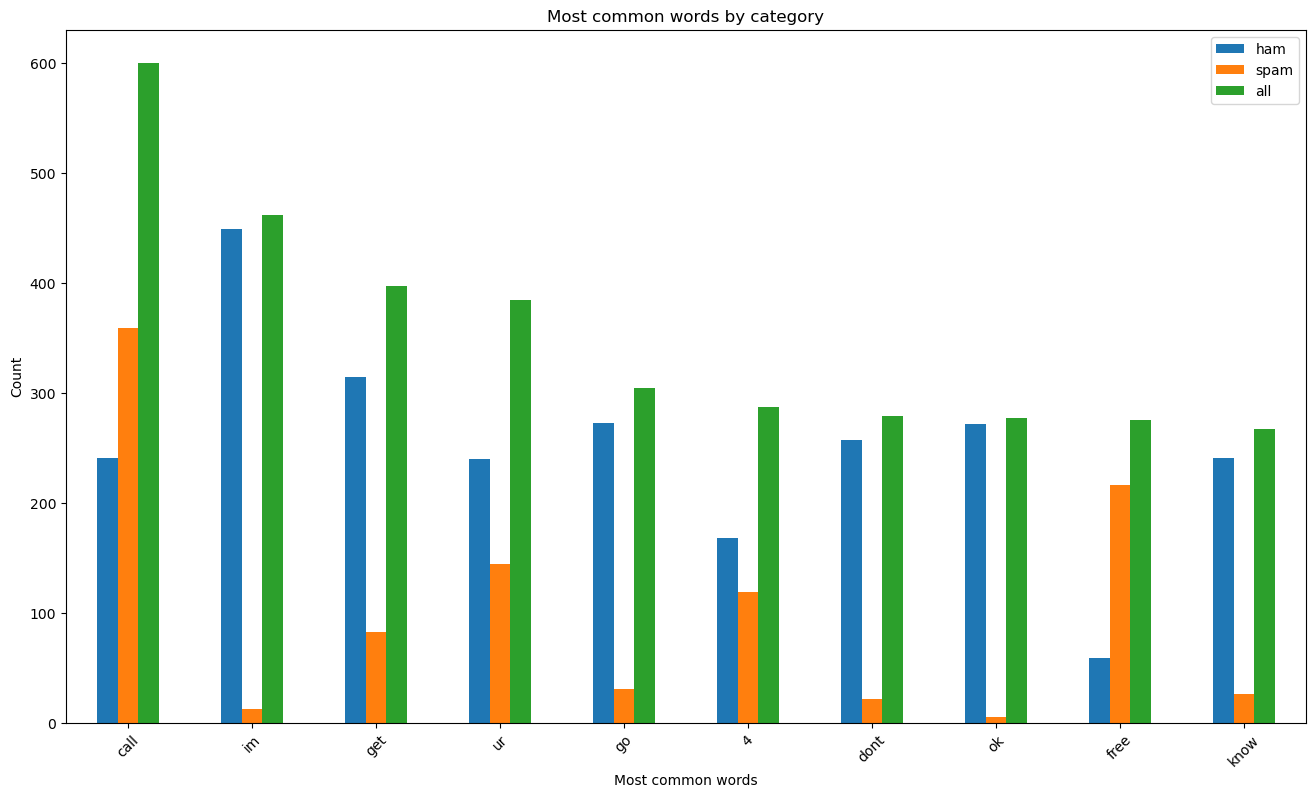

In [20]:
#Plot the most frequent words and color by label
word_freq.sort_values('all', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

In [21]:
#Calculate percentage of all words by label
word_freq['pct_ham'] = word_freq['ham'] / word_freq['all'] * 100
word_freq['pct_spam'] = word_freq['spam'] / word_freq['all'] * 100
word_freq.head()

,ham,spam,all,pct_ham,pct_spam
im,449,13,462,97.186147,2.813853
get,314,83,397,79.093199,20.906801
go,273,31,304,89.802632,10.197368
ok,272,5,277,98.194946,1.805054
dont,257,22,279,92.114695,7.885305


In [22]:
#Look at the highest percent ham words
word_freq[word_freq['ham'] > 200].sort_values('pct_ham', ascending=False)

,ham,spam,all,pct_ham,pct_spam
ill,236,1,237,99.578059,0.421941
ok,272,5,277,98.194946,1.805054
come,242,5,247,97.975709,2.024291
im,449,13,462,97.186147,2.813853
got,231,7,238,97.058824,2.941176
good,223,12,235,94.893617,5.106383
like,232,13,245,94.693878,5.306122
dont,257,22,279,92.114695,7.885305
time,213,19,232,91.810345,8.189655
know,241,26,267,90.262172,9.737828


In [18]:
#Highest percent spam words
word_freq[word_freq['spam'] > 100].sort_values('pct_spam', ascending=False)

,ham,spam,all,pct_ham,pct_spam
claim,0,115,115,0.000000,100.000000
txt,13,150,163,7.975460,92.024540
mobile,15,135,150,10.000000,90.000000
free,59,216,275,21.454545,78.545455
stop,40,113,153,26.143791,73.856209
reply,43,102,145,29.655172,70.344828
text,77,137,214,35.981308,64.018692
call,241,359,600,40.166667,59.833333
4,168,119,287,58.536585,41.463415
ur,240,144,384,62.500000,37.500000


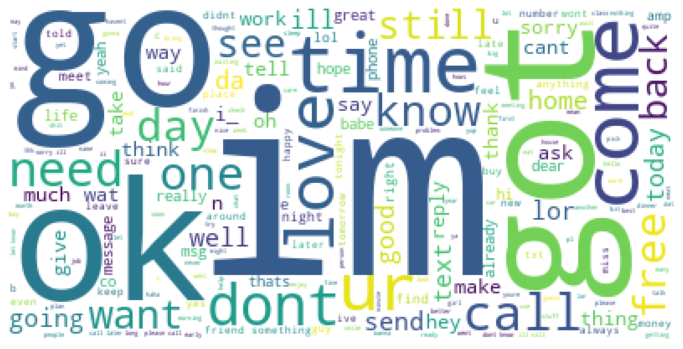

In [19]:
#Word cloud
all_cloud = WordCloud(background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud)
plt.axis('off')
plt.show()

In [27]:
#Bigrams!
ham_bigrams = pd.Series(nltk.ngrams(ham_words, 2))
ham_bigrams.head()

0          (go, jurong)
1       (jurong, point)
2        (point, crazy)
3    (crazy, available)
4    (available, bugis)
dtype: object

In [28]:
#Retrieve the 10 most frequent bigrams
top_ham_bigrams = ham_bigrams.value_counts().head(10)
top_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
dtype: int64

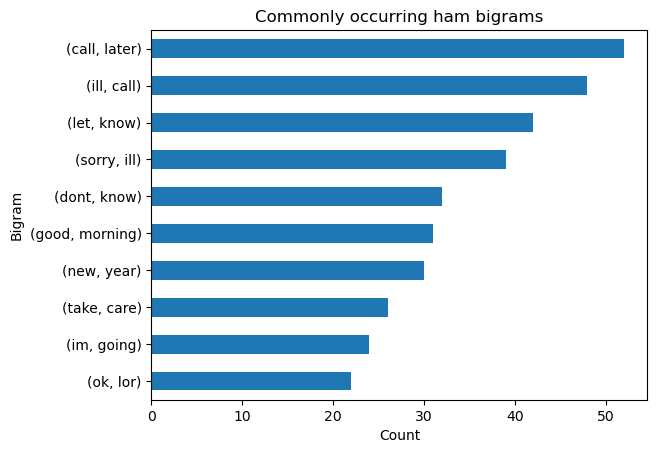

In [30]:
#Plot
top_ham_bigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Commonly occurring ham bigrams')
plt.show()

In [41]:
#Make spam bigrams
spam_bigrams = pd.Series(nltk.ngrams(spam_words, 2))
spam_bigrams.head()

0    (free, entry)
1    (entry, wkly)
2     (wkly, comp)
3      (comp, win)
4        (win, fa)
dtype: object

In [42]:
#Return the 10 most frequent spam bigrams
top_spam_bigrams = spam_bigrams.value_counts().head(10)
top_spam_bigrams

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
(prize, guaranteed)    22
(send, stop)           19
(selected, receive)    19
(await, collection)    19
(every, week)          19
dtype: int64

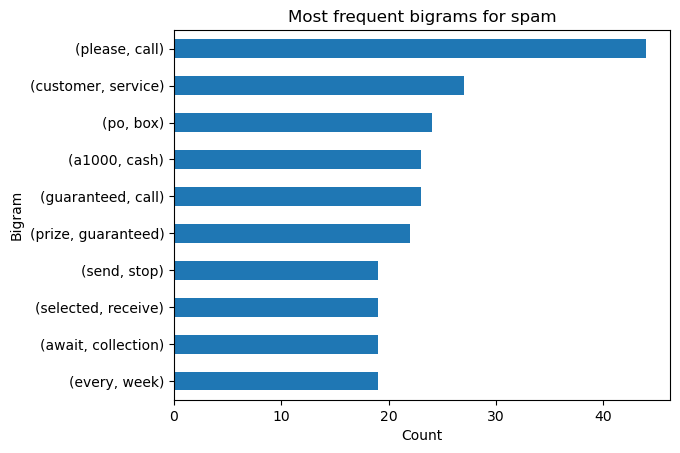

In [38]:
#Plot
top_spam_bigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most frequent bigrams for spam')
plt.show()